# Notebook 2: Exploratory Data Analysis (EDA) & Feature Selection


## Objectives

- Explore the Heart Disease dataset to identify patterns and relationships between features and the target variable.  
  
- Determine the most relevant features for machine learning modeling.  



## Inputs

- `outputs/datasets/collection/heart_disease_raw.csv` (from Notebook 1)  



## Outputs

- Insights and visualizations to guide feature selection.  
  
- List of top candidate variables for modeling.  
  
- Figures saved to `outputs/figures/`.  



## OPTIONAL: Automated Profiling

**Purpose**  

Quickly generate an automated summary of the dataset.  

**Approach**  

Use `ydata_profiling` to create a minimal profiling report.  

**Expected Outcome**  

A high-level overview of dataset distributions, correlations, and potential quality issues.  

---

## Step 2 — Load Dataset

**Purpose**  

Load the raw dataset to confirm correctness and prepare for exploratory analysis.  

**Approach**  

- Import the dataset from the raw inputs folder.  
  
- Display the first five rows to verify structure.  

**Expected Outcome**  

Dataset successfully loaded and verified as consistent with Notebook 1 output.  

In [1]:
import pandas as pd
df = pd.read_csv("/workspaces/Heart_disease_risk_predictor/inputs/datasets/raw/heart_disease_uci.csv")

# Show first 5 rows
print("Dataset loaded successfully! First 5 rows of dataset:")
display(df.head())

Dataset loaded successfully! First 5 rows of dataset:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


---

## Step 2.1 — Target Variable Distribution

**Purpose**  

Understand the distribution of the target variable `num`, which indicates the presence and stage of heart disease.  

**Approach**  

- Plot the proportion of each class in `num`.  
  
- Add percentage labels for clarity.  

**Expected Outcome**  

A clear visualization of class imbalance, showing how many patients have no heart disease (`0`) vs. stages of disease 

(`1–4`).  

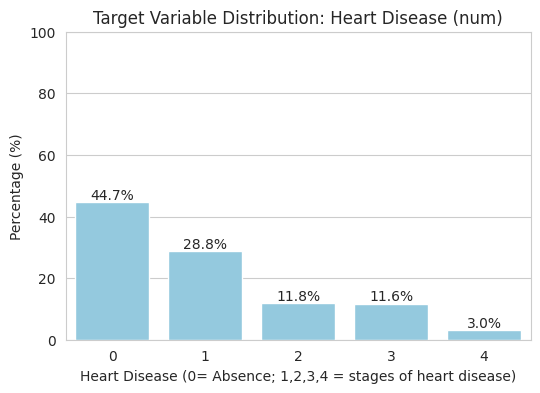

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Calculate percentage distribution
target_percent = df["num"].value_counts(normalize=True) * 100
target_labels = target_percent.index

plt.figure(figsize=(6,4))
sns.barplot(x=target_labels, y=target_percent.values, color="skyblue")

plt.title("Target Variable Distribution: Heart Disease (num)")
plt.xlabel("Heart Disease (0= Absence; 1,2,3,4 = stages of heart disease)")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)  # Ensures y-axis goes from 0 to 100

# Optionally, annotate the bars with the exact percentages
for i, pct in enumerate(target_percent.values):
    plt.text(i, pct + 1, f'{pct:.1f}%', ha='center')

plt.show()

---

## Step 2.2 — Key Features of Interest

**Purpose**  

Identify clinically meaningful variables for exploratory analysis.  

**Selected Features**  

- **Numerical (binned for visualization):**  
  
  - Age - Heart disease risk increases with age.
  
  - Cholesterol (`chol`) - Higher levels are associated with cardiovascular risk.
  
  - Resting Blood Pressure (`trestbps`) - Hypertension is a known risk factor.
  
  - Maximum Heart Rate Achieved (`thalach`) - Lower maximum heart rate may indicate poor cardiac fitness.
  
  - ST Depression (`oldpeak`) - Indicates exercise-induced ischemia.

- **Categorical:**  
  
  - Gender (`sex`) - Males are generally at higher risk.
  
  - Fasting Blood Sugar (`fbs`) - Elevated glucose can contribute to heart disease.
  
  - Chest Pain Type (`cp`) - Different types have varying risk.

**Expected Outcome**  

A focused set of features that combine domain knowledge and exploratory insights.  
 

---

## Step 2.3 — Numerical Feature Distributions

**Purpose**  

Examine the overall distribution of numeric variables to identify skewness, outliers, or unexpected values.  

**Approach** 

- Plot histograms with KDE overlays for all numeric features (excluding the target).  

**Expected Outcome**  

Visual confirmation of numeric feature distributions, highlighting potential variables requiring transformation or 

scaling.  

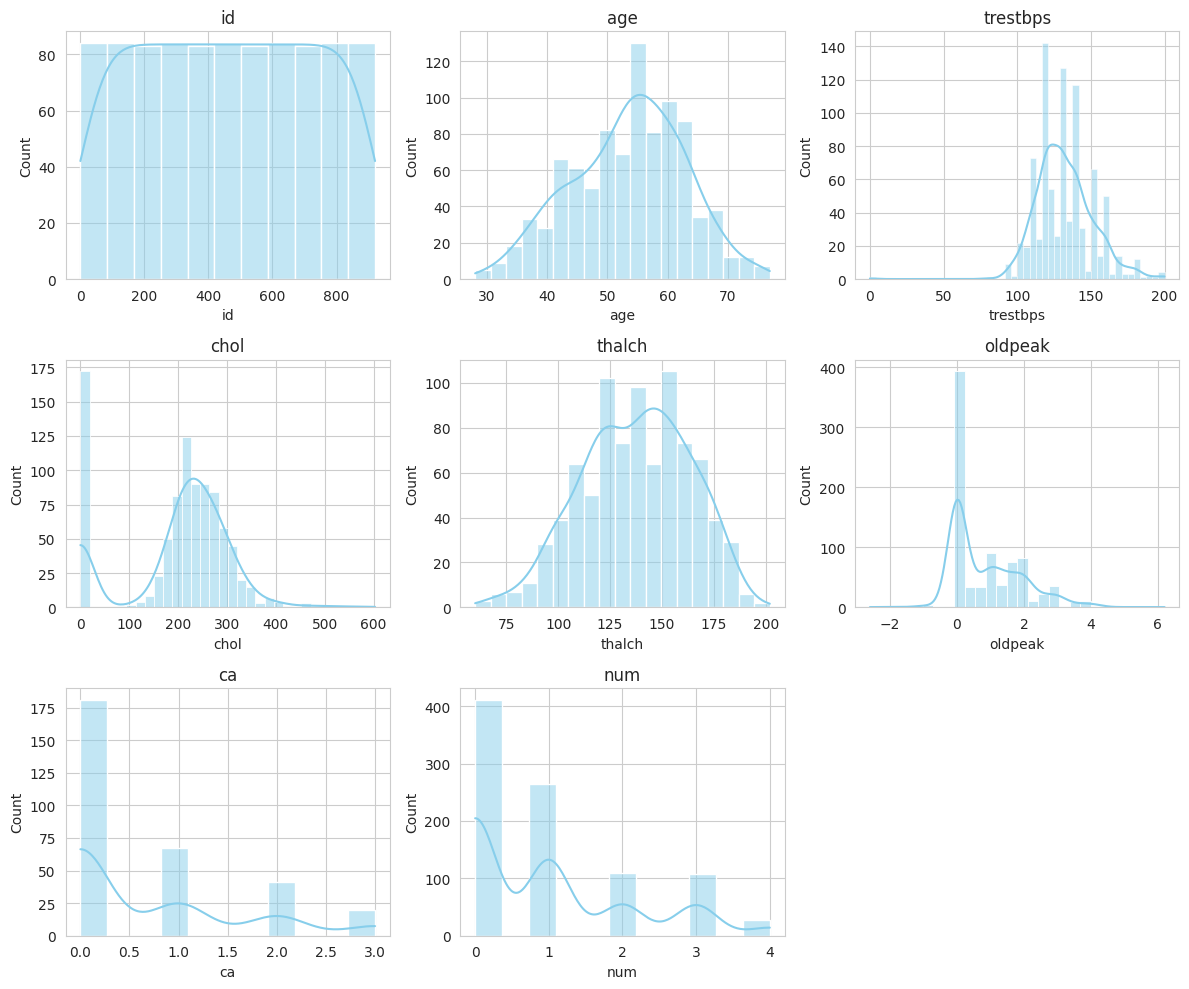

In [3]:
numerical_vars = df.select_dtypes(include='number').columns.tolist()
# numerical_vars.remove('num')  # Exclude target

plt.figure(figsize=(12,10))
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color="skyblue")
    plt.title(col)
plt.tight_layout()
plt.show()

---

## Step 2.4 — Numerical Features (Binned) vs. Target

**Purpose**  

Visualize how the target variable `num` varies across ranges of key numeric variables.  

**Approach**  

- Create clinically meaningful bins for age, cholesterol, resting BP, max heart rate, and ST depression. 
   
- Plot percentage distributions of `num` within each bin.  

**Expected Outcome**  

Intuitive understanding of how different numeric ranges are associated with higher or lower risk of heart disease.  

/tmp/ipykernel_4738/3216452945.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


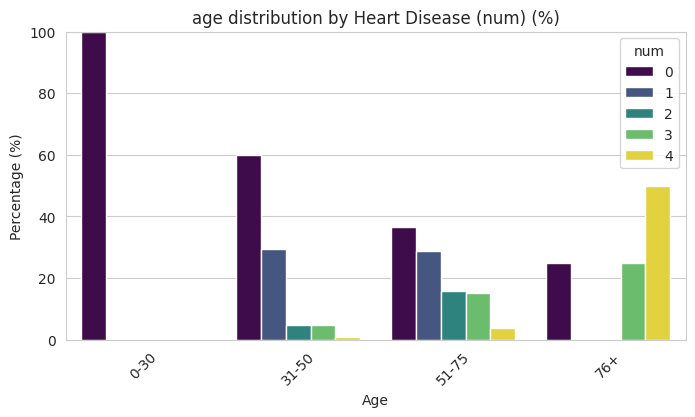

/tmp/ipykernel_4738/3216452945.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


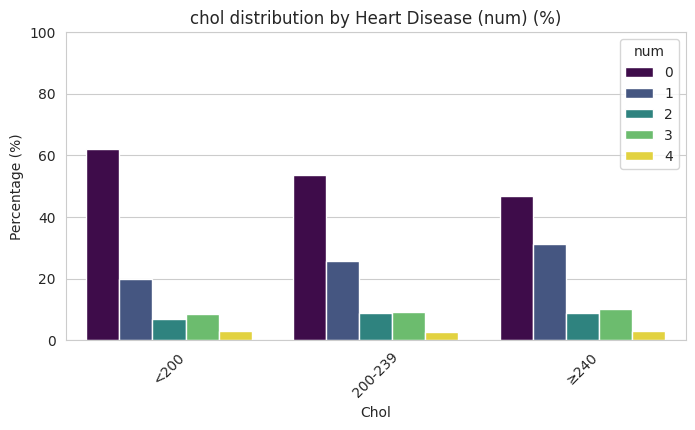

/tmp/ipykernel_4738/3216452945.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


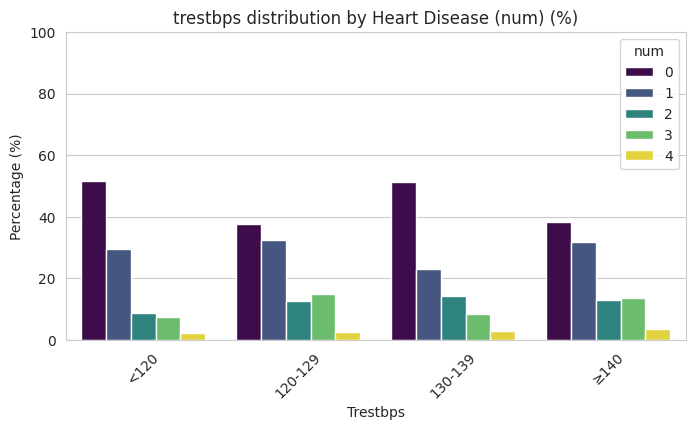

/tmp/ipykernel_4738/3216452945.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


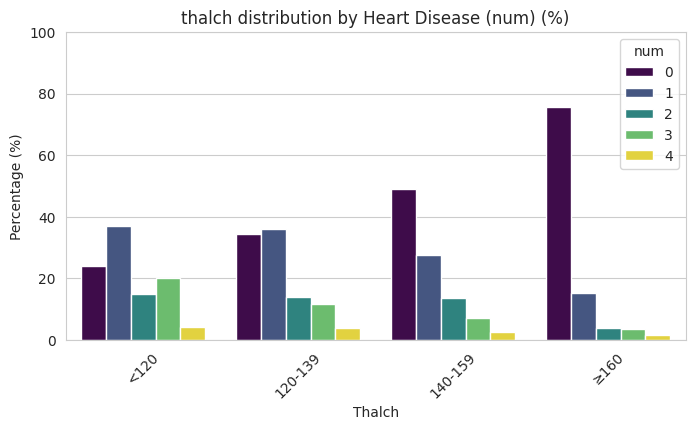

/tmp/ipykernel_4738/3216452945.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(f"{col}_bin")['num']


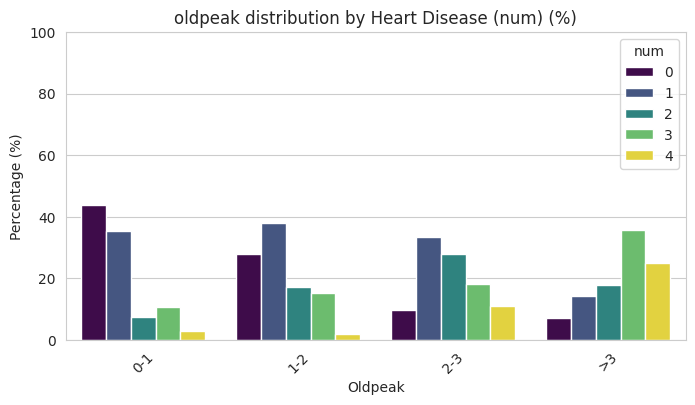

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Define bins
bins_dict = {
    "age": [0, 30, 50, 75, 100],
    "chol": [0, 200, 239, 1000],  # 200 borderline, ≥240 high
    "trestbps": [0, 120, 129, 139, 200],  # normal, elevated, stage1, stage2
    "thalch": [0, 120, 139, 159, 220],
    "oldpeak": [0, 1, 2, 3, 10]
}

labels_dict = {
    "age": ["0-30", "31-50", "51-75", "76+"],
    "chol": ["<200", "200-239", "≥240"],
    "trestbps": ["<120","120-129","130-139","≥140"],
    "thalch": ["<120","120-139","140-159","≥160"],
    "oldpeak": ["0-1","1-2","2-3",">3"]
}

# Bin and plot
for col in bins_dict.keys():
    df[f"{col}_bin"] = pd.cut(df[col], bins=bins_dict[col], labels=labels_dict[col])
    
    # Plot distribution by target
    plt.figure(figsize=(8,4))
    cat_percentages = (
        df.groupby(f"{col}_bin")['num']
        .value_counts(normalize=True)
        .mul(100)
        .rename("percentage")
        .reset_index()
    )
    
    sns.barplot(
        data=cat_percentages,
        x=f"{col}_bin", y="percentage",
        hue="num",
        palette=sns.color_palette("viridis", as_cmap=True),
        order=labels_dict[col]
    )
    
    plt.title(f"{col} distribution by Heart Disease (num) (%)")
    plt.ylabel("Percentage (%)")
    plt.xlabel(col.capitalize())
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.show()

---

## Step 2.5 — Categorical Variables Overview

**Purpose**  

Identify categorical variables and explore their distributions.  

**Approach**  

- Print unique values and top frequencies for each categorical variable. 
   
- Investigate potential imbalances across categories.  

**Expected Outcome**  

A better understanding of categorical variable composition, highlighting any skew or underrepresented categories.  

In [5]:
categorical_vars = df.select_dtypes(include='object').columns.tolist()

for col in categorical_vars:
    print(f"--- {col} ---")
    print(f"Unique values: {df[col].nunique()}")
    print(df[col].value_counts().head(5))  # Top 5 most frequent
    print("\n")

--- sex ---
Unique values: 2
sex
Male      726
Female    194
Name: count, dtype: int64


--- dataset ---
Unique values: 4
dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64


--- cp ---
Unique values: 4
cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64


--- fbs ---
Unique values: 2
fbs
False    692
True     138
Name: count, dtype: int64


--- restecg ---
Unique values: 3
restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64


--- exang ---
Unique values: 2
exang
False    528
True     337
Name: count, dtype: int64


--- slope ---
Unique values: 3
slope
flat           345
upsloping      203
downsloping     63
Name: count, dtype: int64


--- thal ---
Unique values: 3
thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64




---

## Step 2.6 — Gender vs. Target Distribution

**Purpose**  

Evaluate whether the prevalence of heart disease differs between male and female patients.  

**Approach**  

- Calculate the percentage of heart disease cases (`num`) within each gender group.  

**Expected Outcome** 
 
Quantitative insight into gender-related disparities in heart disease prevalence.  

In [6]:
if 'sex' in df.columns:
    sex_disease_percentage = (
        df.groupby('sex')['num']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
    )
    print("Heart Disease Percentage by Gender:")
    print(sex_disease_percentage)

Heart Disease Percentage by Gender:
      sex  num  percentage
0  Female    0   74.226804
1  Female    1   15.463918
2  Female    2    5.154639
3  Female    3    4.123711
4  Female    4    1.030928
5    Male    0   36.776860
6    Male    1   32.369146
7    Male    2   13.636364
8    Male    3   13.636364
9    Male    4    3.581267


---

## Step 2.7 — Categorical Features Distribution vs. Target

**Purpose**  

Examine how the target variable `num` is distributed across categories of each categorical variable.  

**Approach**  

- For each categorical variable (with ≤ 15 unique values), plot bar charts showing the percentage distribution of 
  
  `num`.  

**Expected Outcome**  

Visual insights into how categorical predictors (e.g., chest pain type, fasting blood sugar, gender) are associated with 

different stages of heart disease.  

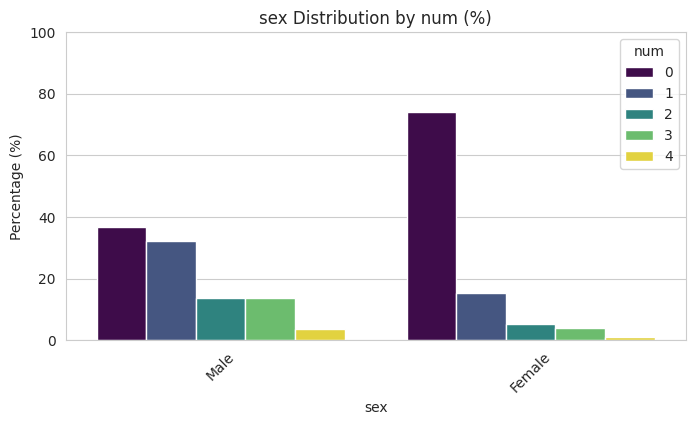

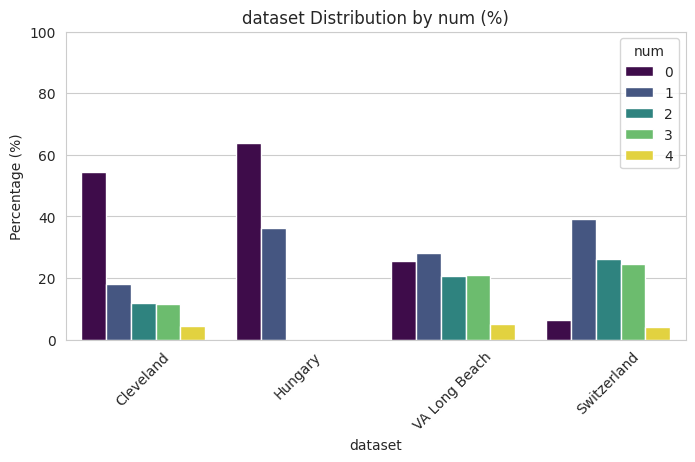

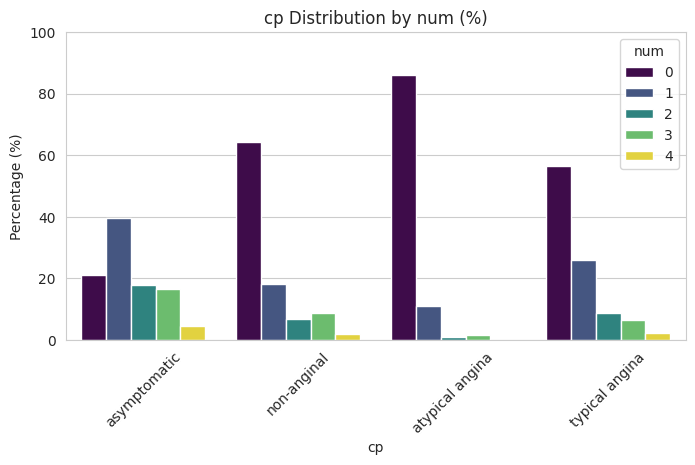

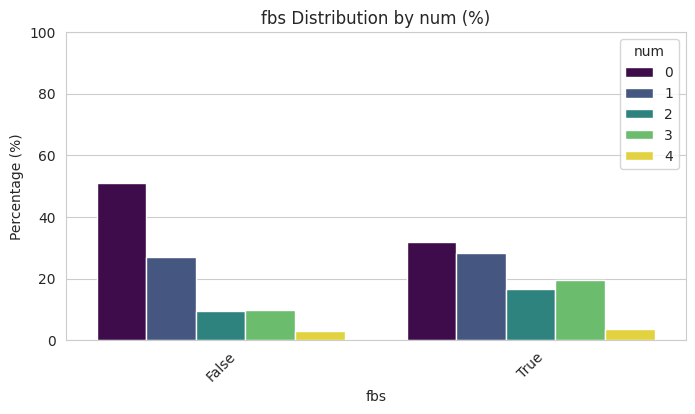

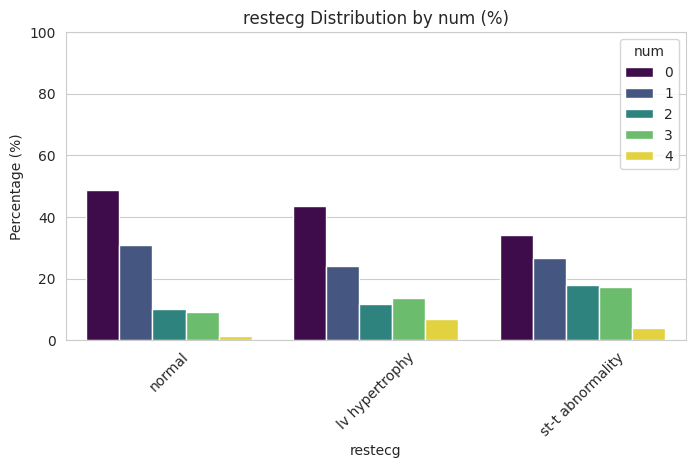

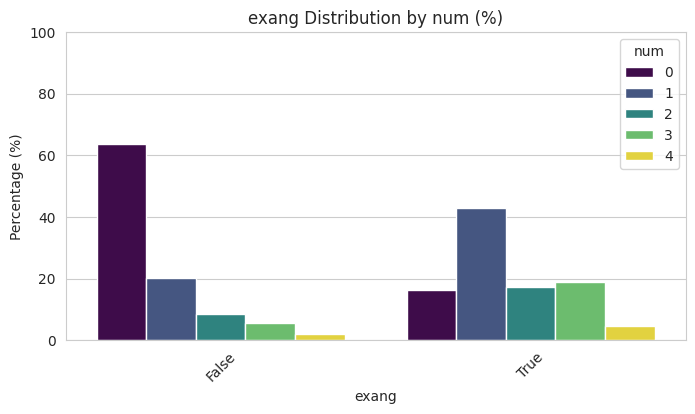

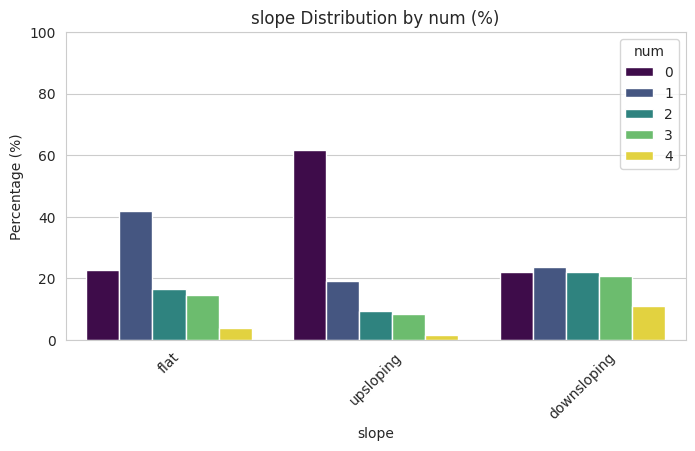

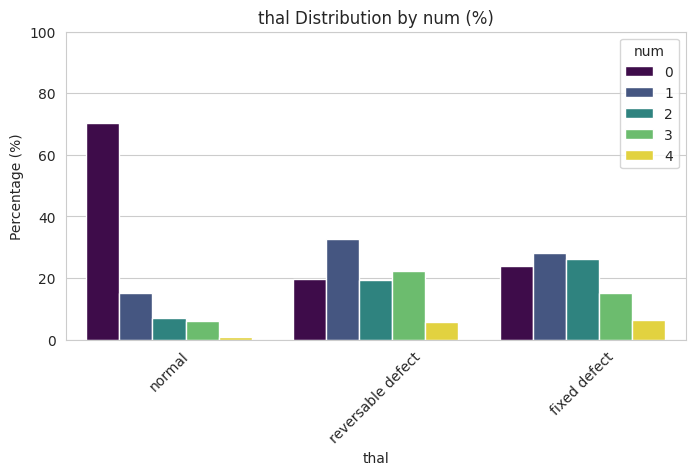

In [7]:
categorical_vars = df.select_dtypes(include='object').columns.tolist()

def plot_categorical_percent(df, col, target="num"):
    plt.figure(figsize=(8,4))
    
    # Calculate percentages within each category
    cat_percentages = (
        df.groupby(col)[target]
        .value_counts(normalize=True)  # relative to each category
        .mul(100)
        .rename("percentage")
        .reset_index()
    )
    
    sns.barplot(
        data=cat_percentages,
        x=col, y="percentage",
        hue=target,
        palette=sns.color_palette("viridis", as_cmap=True),
        order=df[col].value_counts().index
    )
    
    plt.xticks(rotation=45)
    plt.ylabel("Percentage (%)")
    plt.title(f"{col} Distribution by {target} (%)")
    plt.ylim(0, 100)
    plt.show()

# Loop through and plot
for col in categorical_vars:
    if df[col].nunique() <= 15:  # Avoid overly cluttered plots
        plot_categorical_percent(df, col)


---

## Step 2.8 — Correlation Analysis

**Purpose**  

Quantify relationships between numeric features and the target `num`.  

**Approach**  

- Compute Spearman correlation (non-linear + rank-based).  

- Compute Pearson correlation (linear).  
  
- Sort by absolute correlation with `num`.  

**Expected Outcome**  

Ranked list of features most strongly correlated with heart disease, serving as candidates for model input.  

In [8]:
numeric_cols = df.select_dtypes(include='number')
corr_spearman = numeric_cols.corr(method='spearman')['num'].sort_values(key=abs, ascending=False)[1:]
print("Top correlations with target (Spearman):")
display(corr_spearman.head(10))

corr_pearson = numeric_cols.corr(method='pearson')['num'].sort_values(key=abs, ascending=False)[1:]
print("Top correlations with target (Pearson):")
display(corr_pearson.head(10))




Top correlations with target (Spearman):


ca          0.528047
oldpeak     0.434273
thalch     -0.398360
age         0.347184
id          0.325659
chol       -0.157563
trestbps    0.126805
Name: num, dtype: float64

Top correlations with target (Pearson):


ca          0.516216
oldpeak     0.443084
thalch     -0.366265
age         0.339596
id          0.273552
chol       -0.231547
trestbps    0.122291
Name: num, dtype: float64

---

## Step 2.9 — Feature Selection for Modeling

**Purpose**  

Narrow down the feature set to the most predictive variables for machine learning.  

**Approach**  

- Select top features from Spearman and Pearson correlations. 
   
- Merge into a combined candidate feature list.  

**Expected Outcome**  

A concise set of high-priority features to be used in Notebook 3 (Data Cleaning & Preprocessing).  


In [9]:
top_features = list(set(corr_spearman.head(5).index.to_list() + corr_pearson.head(5).index.to_list()))
print("Candidate features for modeling:")
print(top_features)

Candidate features for modeling:
['ca', 'age', 'id', 'thalch', 'oldpeak']


## Step 2.10 — Visualization of Feature Relationships

**Purpose**  

Explore feature interactions and their relationship with the target variable.  

**Approach**  

- Pairplots for top correlated features. 
   
- Heatmaps of correlations (overall + by target class). 
   
- Highlight top 3 correlated features with the target using Spearman correlation.  

**Expected Outcome**  

Deeper visual insights into how features interact, and confirmation of redundancy or complementary value among 

predictors.  

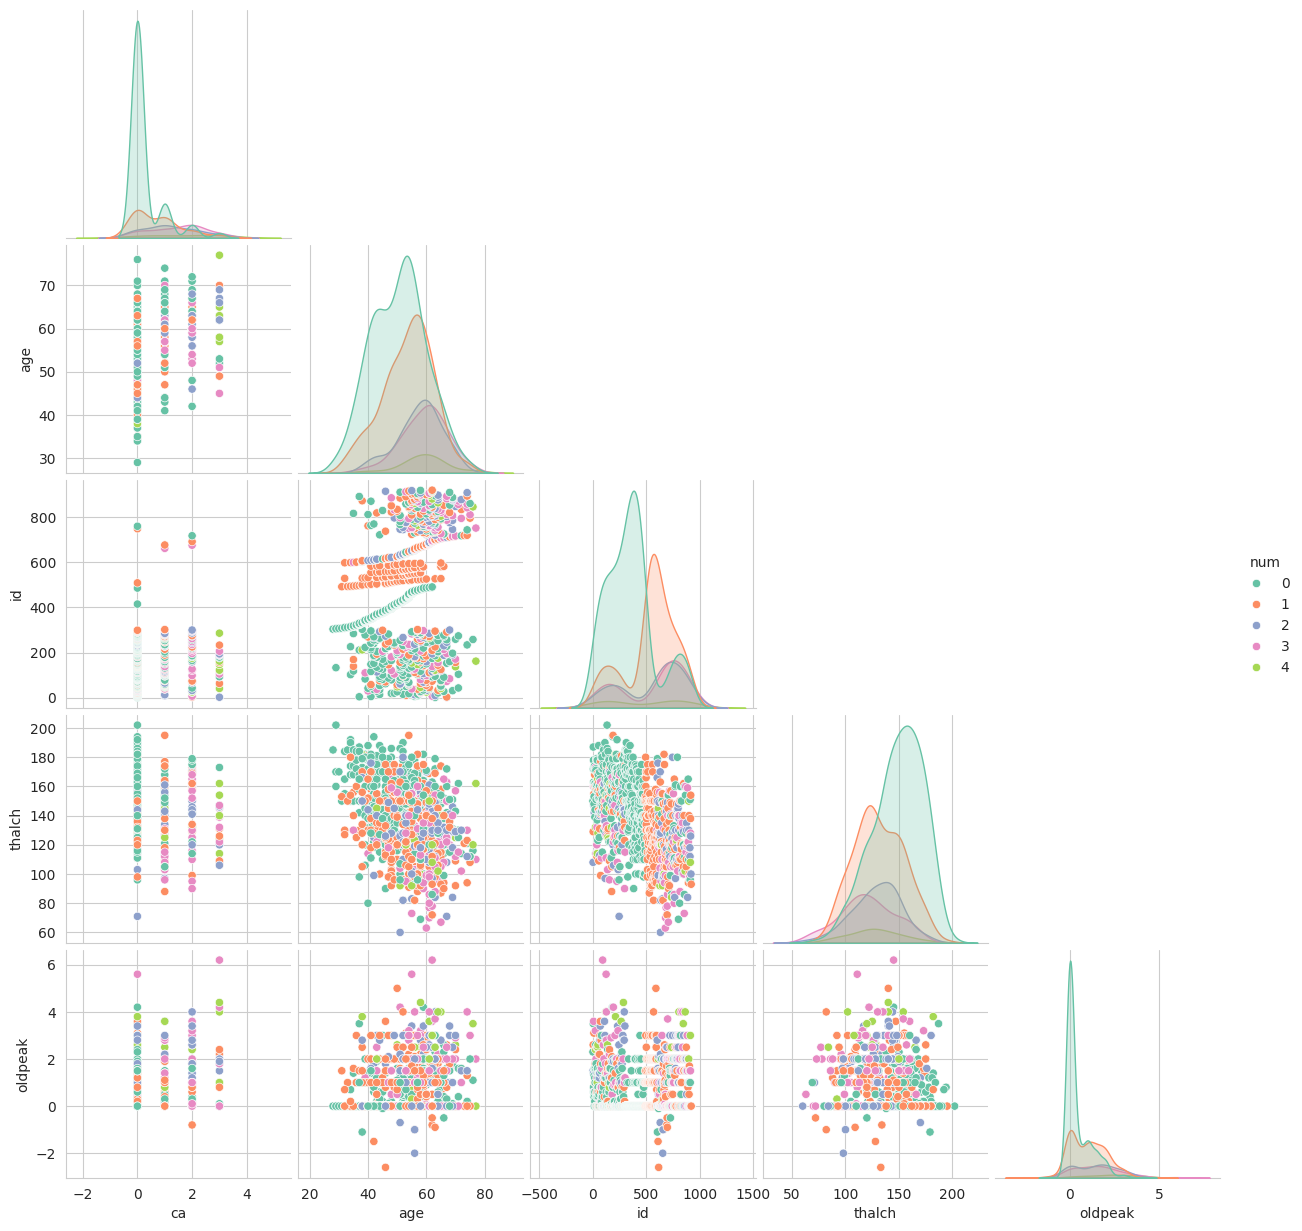

In [10]:
sns.pairplot(df[top_features + ['num']], hue='num', corner=True, palette="Set2")
plt.show()

In [11]:
df[col].nunique()

df[col].value_counts().head(20)

thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64

Correlation Heatmap

A heatmap allows us to quickly see the relationships among the selected features and the target variable `num`.


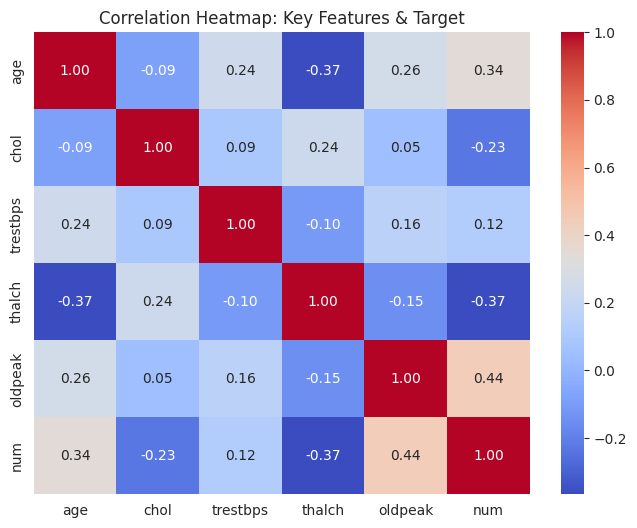

In [12]:
key_features = ['age', 'chol', 'trestbps', 'thalch', 'oldpeak', 'num']  # include target for correlation

plt.figure(figsize=(8,6))
sns.heatmap(df[key_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Key Features & Target")
plt.show()

Pairplot / Multi-dimensional Visualization
 
Pairplots allow us to observe feature interactions and how they relate to the target variable `num`. 
We can also include `sex` as hue to see potential gender differences in feature distributions.


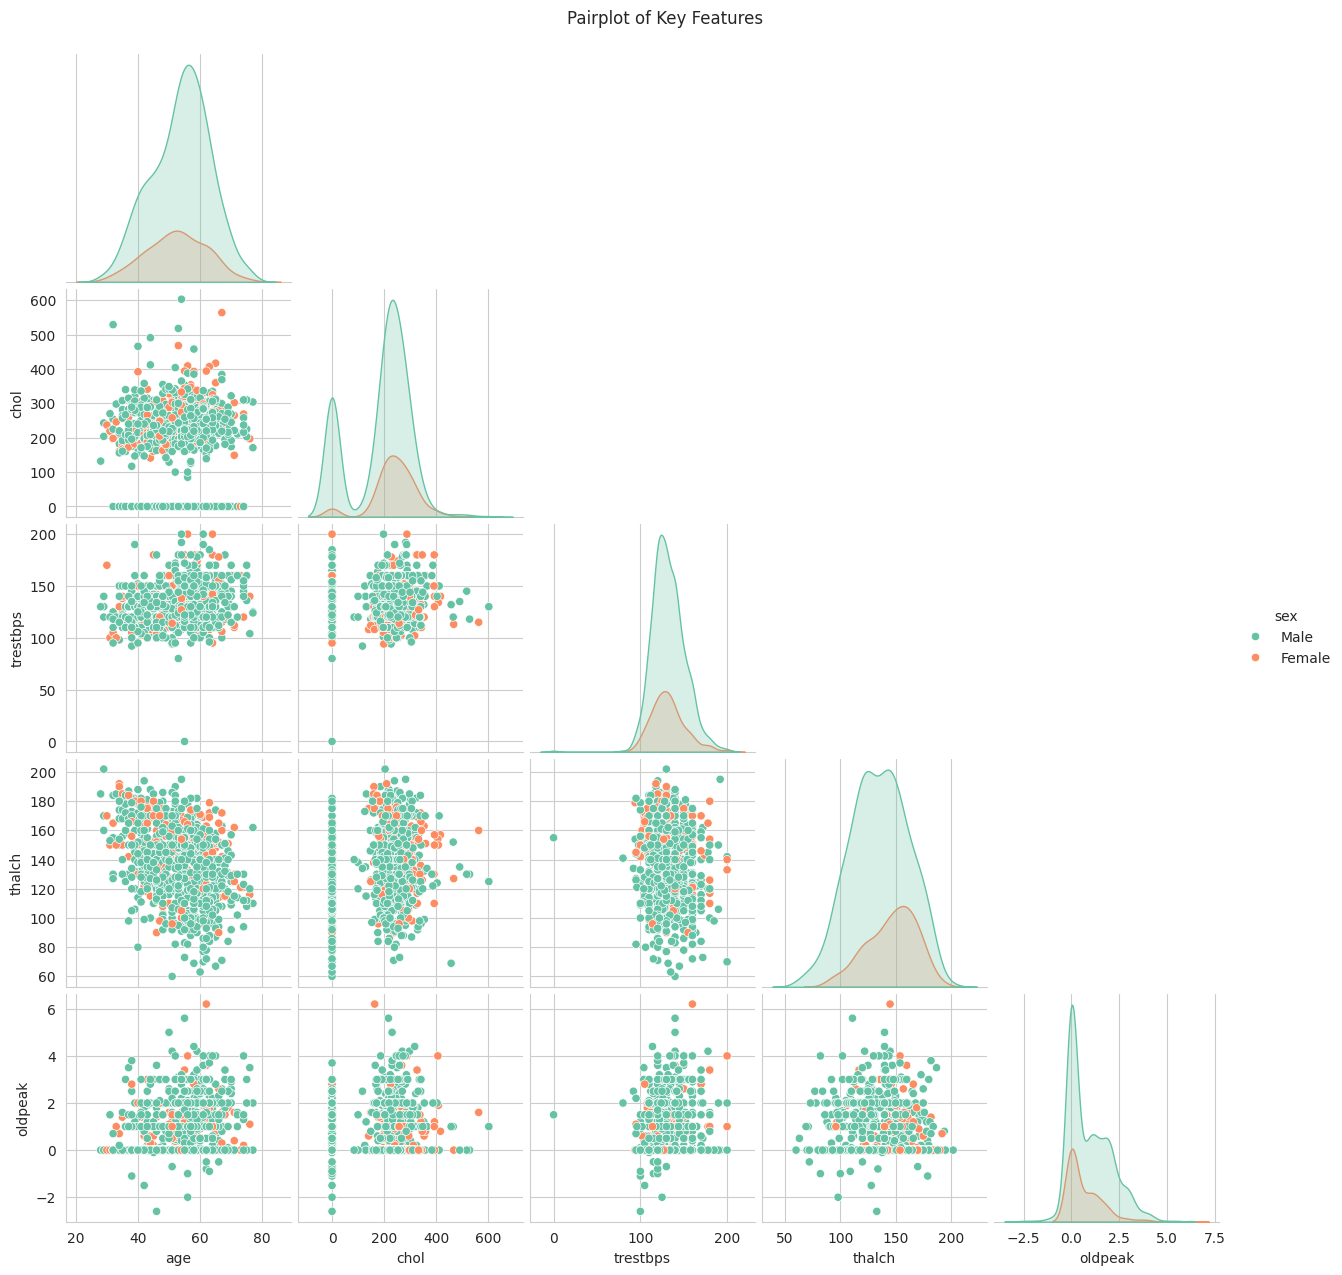

In [13]:
sns.pairplot(
    df[key_features + ['sex']] if 'sex' in df.columns else df[key_features],
    hue='sex' if 'sex' in df.columns else 'num',
    vars=['age', 'chol', 'trestbps', 'thalch', 'oldpeak'],
    corner=True,
    palette='Set2',
    diag_kind='kde'
)
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

Overall correlation

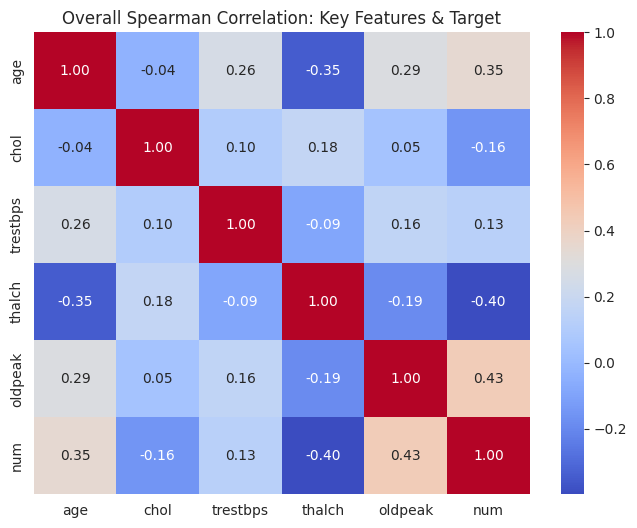

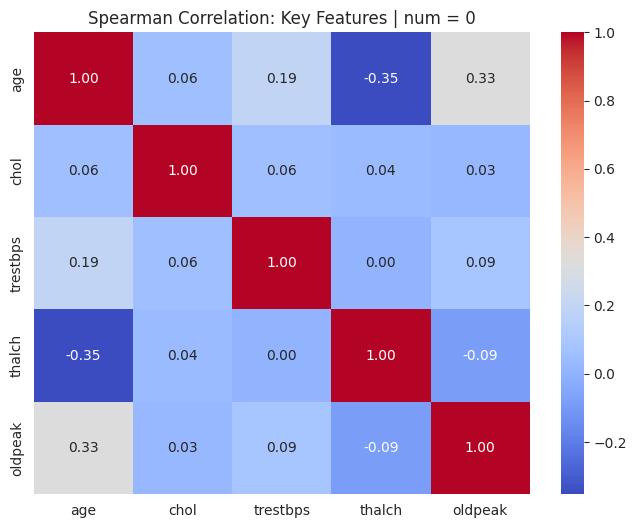

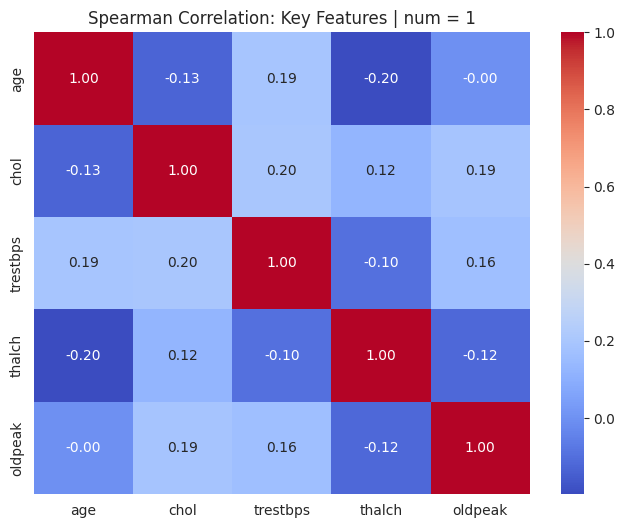

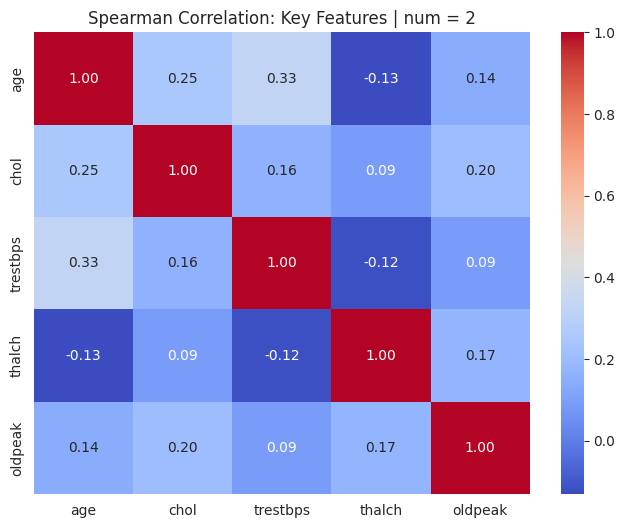

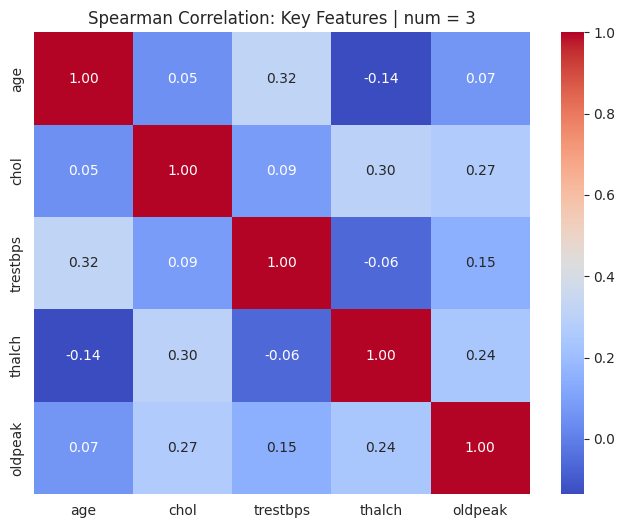

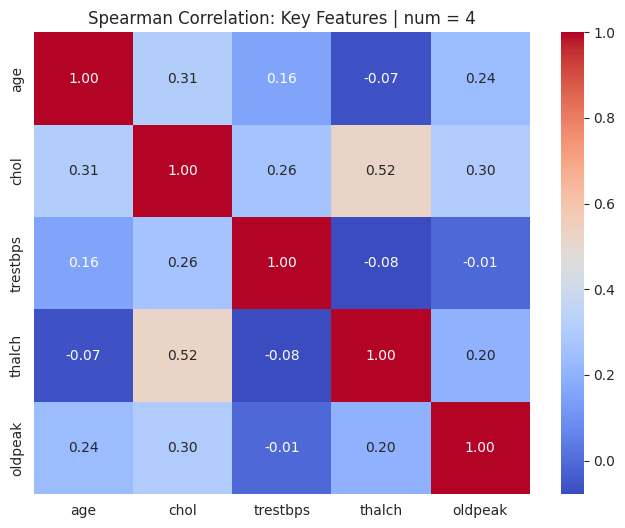

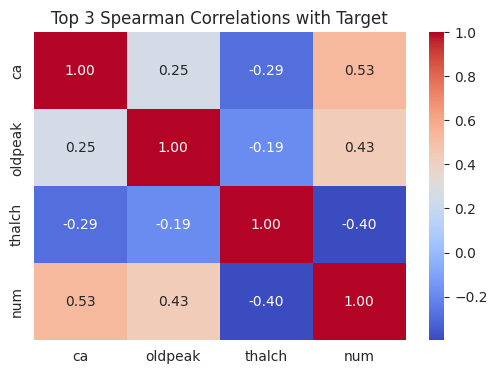

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(df[key_features].corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Overall Spearman Correlation: Key Features & Target")
plt.show()

# Separate correlations by binary classification
for label in sorted(df['num'].unique()):
    subset = df[df['num'] == label][key_features[:-1]]  # exclude target from features
    plt.figure(figsize=(8,6))
    sns.heatmap(subset.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Spearman Correlation: Key Features | num = {label}")
    plt.show()

# Top correlations with target only
numeric_cols = df.select_dtypes(include='number')
corr_spearman = numeric_cols.corr(method='spearman')['num'].drop('num').sort_values(key=abs, ascending=False)
top_features = corr_spearman.head(3).index.tolist()

plt.figure(figsize=(6,4))
sns.heatmap(df[top_features + ['num']].corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 3 Spearman Correlations with Target")
plt.show()


---

# ✅ Conclusion — Exploratory Data Analysis & Feature Selection

In this notebook, we performed a comprehensive **EDA and feature selection** process.  

**Summary of Work Completed**

1. Verified dataset integrity by reloading from raw inputs.  
   
2. Examined **target variable distribution** (imbalanced but usable). 
    
3. Identified **key numerical and categorical features** for exploration. 
    
4. Visualized **numerical distributions** and their relationships with heart disease stages.
     
5. Assessed **categorical distributions** across target classes.  
   
6. Conducted **correlation analysis** (Spearman & Pearson) to rank features.  
   
7. Compiled a **candidate feature list** for downstream modeling. 
    
8. Produced **visual insights** (histograms, bar plots, heatmaps, pairplots) for both univariate and multivariate relationships.  

---

### 🔮 Next Steps (Notebook 3)

The insights from EDA guide the **data cleaning and preprocessing pipeline**: 

- Handle missing values and invalid entries.  
  
- Encode categorical features.  
  
- Normalize/scale numerical features where appropriate.  
  
- Finalize the feature set for modeling.  

This ensures that the transition from **exploration → preparation → modeling** remains consistent and well-documented.  